In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans  # MiniBatchKMeans really helps to fasten processing time
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import math as math

In [2]:
class LemmaTokenizer(object):
    """Custom tokenizer class that stems tokens"""
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in wordpunct_tokenize(doc) if len(t.strip()) > 1]
    
def show_topn(classifier,vectorizer,categories,n):
    """Returns the top n features that characterize eachc category"""
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        topn = np.argsort(classifier.coef_[i])[-n:]
        print('{}: {}'.format(category,", ".join(feature_names[topn])))
        
def save_topn(classifier,vectorizer,categories,n,outdict):
    """Returns the top n features that characterize eachc category, and save result in outdict"""
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        topn = np.argsort(classifier.coef_[i])[-n:]
        outdict[i] = feature_names[topn]

In [3]:
# read in a few columns from the data and show the top of the resulting dataframe
df = pd.read_csv('C:/Users/fahmida/Desktop/Rental/airbnb/Large Files/listings.csv.gz', usecols = ['id', 'name', 'space', 'description', 'neighborhood_overview', 'neighbourhood_cleansed'])

df.head()

,id,name,space,description,neighborhood_overview,neighbourhood_cleansed
0,1419,Beautiful home in amazing area!,Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,Little Portugal
1,8077,Downtown Harbourfront Private Room,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,NaN,Waterfront Communities-The Island
2,12604,Seaton Village Parlour Bedroom,Family of 4 (2 kids) plus a friendly dog open...,Comfortable sofa bed in airy main floor parlou...,NaN,Annex
3,23691,Queen Bedroom close to downtown,Nestled in the middle of a quiet residential n...,Nestled in the middle of a quiet residential n...,NaN,Briar Hill-Belgravia
4,26654,"World Class downtown@ CN Tower! Jays, TIFF, ACC",Welcome to 5***** Living - Bohemian decor~ in ...,"CN Tower, TIFF Bell Lightbox, Metro Convention...",NaN,Waterfront Communities-The Island


In [4]:
# let's combine the name, space, description, and neighborhood_overview into a new column
df['combined_description'] = df.apply(lambda x: '{} {} {} {}'.format(x['name'], x['space'], x['description'], x['neighborhood_overview']), axis=1)
print(df.loc[0,'combined_description'])

Beautiful home in amazing area! Visit Toronto with this fabulous furnished home as your base! This lovely home is surrounded by gardens in the back and front. Inside, you'll find a large open space with a modern kitchen and bright living and dining room. There are two floors up - a master bedroom with a king-size bed and two kids rooms, each with a single bed. The attic is a private space with a king-sized bed, fold-out single couch and a private deck. The basement is fully-finished with a private room and bath, as well as a playroom with another single couch that doubles as a sleeping space. The house will comfortably sleep 10.  For kids of all ages: we have toys, a very cool tree fort, and many great parks and playgrounds nearby. This large, family home is located in one of Toronto's most vibrant downtown neighbourhoods. The five-bedroom, three-bath house is newly renovated and complete with all the amenities you'll need for a fabulous time in the city. Visit Toronto with this fabulo

In [21]:
import nltk
df.sample(n=200)
nltk.download('wordnet')
# Transform combined_description into tfidf format
tfidf = TfidfVectorizer(ngram_range=(1,2),stop_words='english',tokenizer=LemmaTokenizer())
tfidf.fit(df['combined_description'])
DescTfidf = tfidf.transform(df['combined_description'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fahmida\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'ha', u'le', u'u', u'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [22]:
df.to_csv('C:/Users/fahmida/Desktop/Rental/airbnb/Large Files/neighbourhood.clustering.csv')

NameError: name 'os' is not defined

Text(0.5,1,'Number of Listings in Each Neighbourhood')

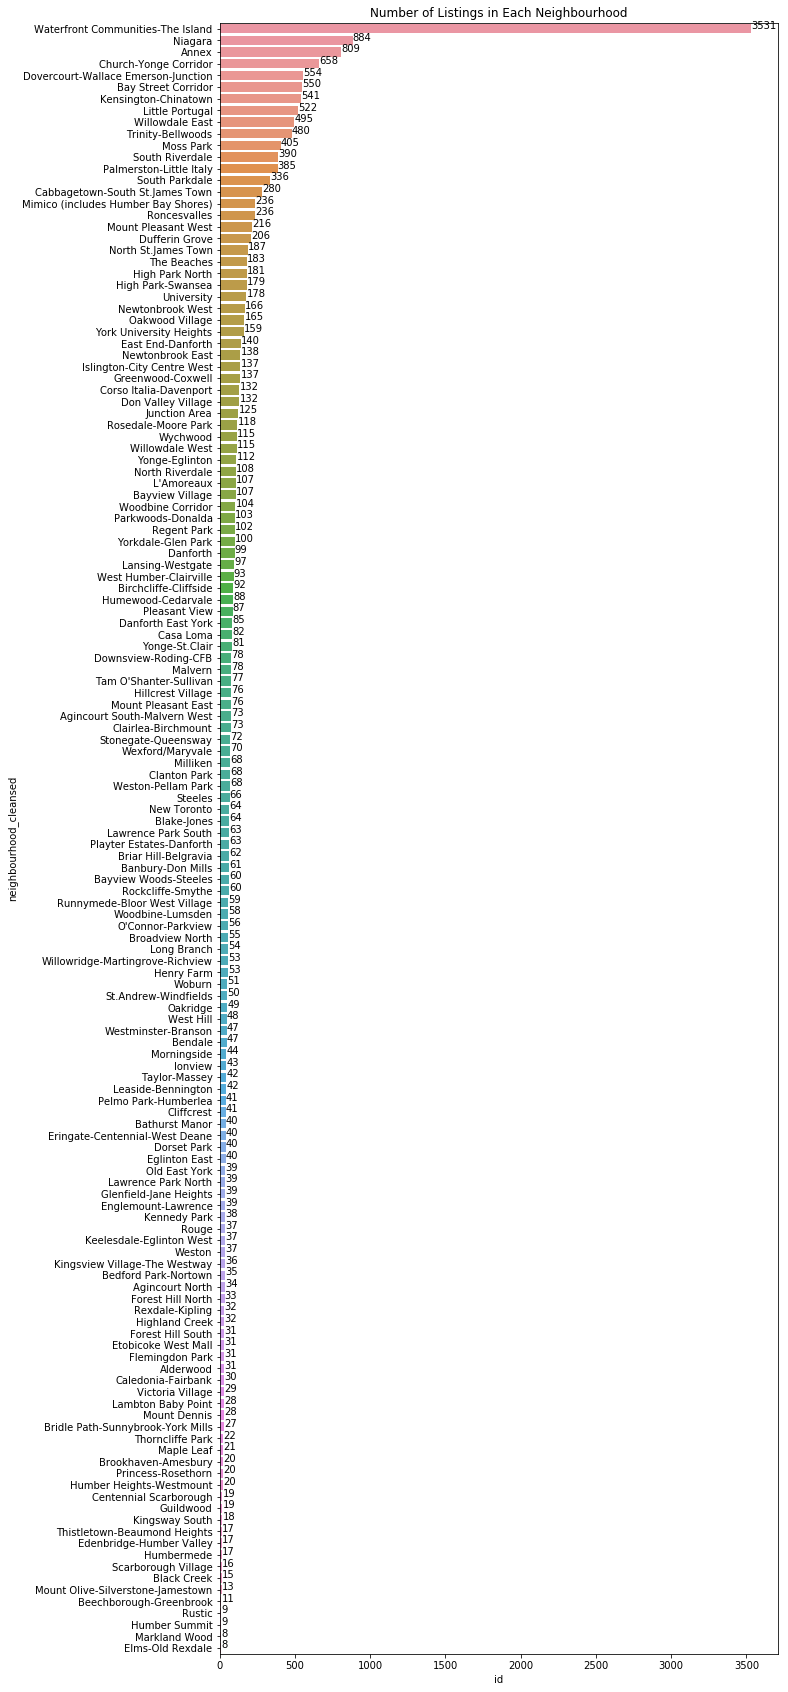

In [23]:
# I added a chart to replace tabulation in the original notebook
neighborRank = df.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False)
# print(neighborRank)
plt.figure(figsize=(10,30))
g = sns.barplot(y=neighborRank.index,x=neighborRank["id"])
# The line below adds the value label in each bar
[g.text(p[1]+1,p[0],p[1], color='black') for p in zip(g.get_yticks(), neighborRank["id"])]
plt.title('Number of Listings in Each Neighbourhood')

In [30]:
# Pipeline to identify top 30 words that are "best predictor" of a cluster
pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words='english', tokenizer=LemmaTokenizer())),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),])

In [31]:
le = LabelEncoder()
new_target = le.fit_transform(df['neighbourhood_cleansed'])
model = pipeline.fit(df['combined_description'], new_target)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'ha', u'le', u'u', u'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [32]:
show_topn(model.named_steps['clf'], model.named_steps['tfidf'], le.inverse_transform(model.named_steps['clf'].classes_), 5)

Agincourt North: walk basement, private shared, like setting, room hotel, laundry washroom
Agincourt South-Malvern West: reliable nan, fibre super, unlimited fibre, second flr, specious second
Alderwood: garden mall, alderwood, yes, sherway garden, sherway
Annex: heart yorkville, premium, window view, annex, yorkville
Banbury-Don Mills: aga, edward, edward garden, don, shop don
Bathurst Manor: 22ftx14ft, sheppard, bathurst manor, near sheppard, sheppard west
Bay Street Corridor: queen park, bay street, hospital, bay college, bay
Bayview Village: loblaws superstore, village mall, village, bayview, bayview village
Bayview Woods-Steeles: kalguksu noodle, noodle shop, great appealing, sandwich asian, kalguksu
Bedford Park-Nortown: including vitamix, close public, apartment style, avenue, avenue road
Beechborough-Greenbrook: close keele, attic person, englinton master, keele englinton, englinton
Bendale: rt station, town centre, midland rt, rt, scarborough
Birchcliffe-Cliffside: cliff, king

UnicodeEncodeError: 'ascii' codec can't encode characters in position 42-45: ordinal not in range(128)